# Basic example of analysis of exoplanet existance

Lightkurve is a Python tool for analysis of time series data on the brightness of planets, stars, and galaxies.

The package is focused on supporting the data from [Kepler](https://en.wikipedia.org/wiki/Kepler_space_telescope) and [TESS](https://en.wikipedia.org/wiki/Transiting_Exoplanet_Survey_Satellite) space telescopes, and defines a way to convert raw data to format, convinient for
analysis, and implements some handy statistical tools for analysis of resulting data.

This notebook focuses on analysis of data of a star, for which it is known that exoplanet could be detected. It will show how applying simple statistic methods could result in investigation of a exoplanet in a galaxy. 

In [49]:
import lightkurve as lk
import numpy as np

%matplotlib inline

## Loading and preprocessing the data
The raw data from Kepler Tess telescopes is presented as Target Pixel Files (TPFs). It contains sequence of measurements of light signals, cutted by the region of observation and quarters of the year.

This format is not convinient to work with, so further in this chapter it would be converted to a more useful format, `LightCurve`

Let's first load some data. This example would investigate `Kepler-8` [planetary system](https://www.openexoplanetcatalogue.com/planet/Kepler-8%20b/), which is known to contain at least one planet in it. 

We will load and investigate 8-th quarter of exploration and try to catch a planet in it.

In [50]:
# It will take a while to find a URL and download a file
search_result = lk.search_targetpixelfile('KIC 6922244', author="Kepler", cadence="long", quarter=8)

In [51]:
target_pixels = search_result.download()
target_pixels.animate()

This datatype is not very convinient to work with. Instead, it would be nice to have a 1D array, containing time series of star's brightness. This exactly what `LightCurve` class represents.

To convert our data in this format, we need to remember that the light from the star is actually distributed among several different pixels. Because of this spreading, we have to sum up many pixels to collect all the light from the source. To do this we sum up all the pixels in an **aperture** -- pixel mask, where we take only the pixels related to the target.

Kepler has his aperture predefined, and we can take a look at it:

<Axes: title={'center': 'Target ID: 6922244, Cadence: 30657'}, xlabel='Pixel Column Number', ylabel='Pixel Row Number'>

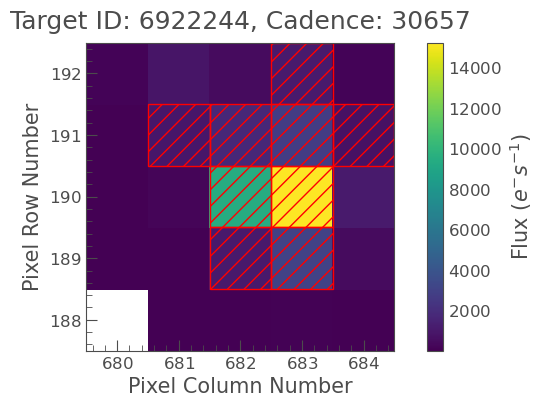

In [52]:
target_pixels.plot(aperture_mask=target_pixels.pipeline_mask)

Let's construct `LightCurve` object:

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Flux [$\\mathrm{e^{-}\\,s^{-1}}$]'>

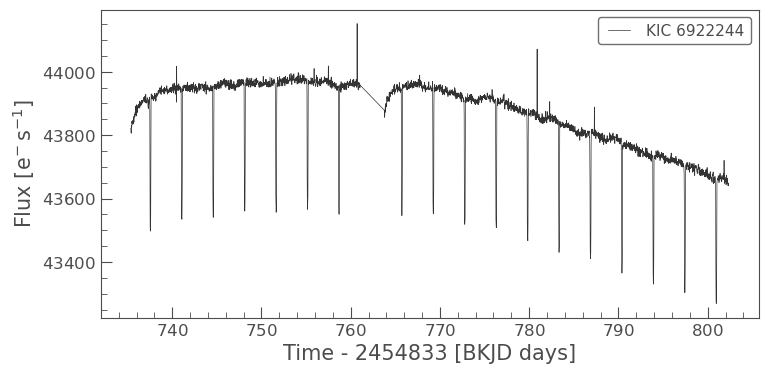

In [53]:
light_curve = target_pixels.to_lightcurve(aperture_mask=target_pixels.pipeline_mask)
light_curve.plot()

The problem with this data is a presence of long-term decline tendency. To eliminate it, let's use [Savitzky–Golay filter](https://en.wikipedia.org/wiki/Savitzky–Golay_filter). This filter is a simple convolution over specified horizon with coefficients found as a solution to least squares problem.

This filter is implemented via `flatten()` method of `LightCurve` instance.

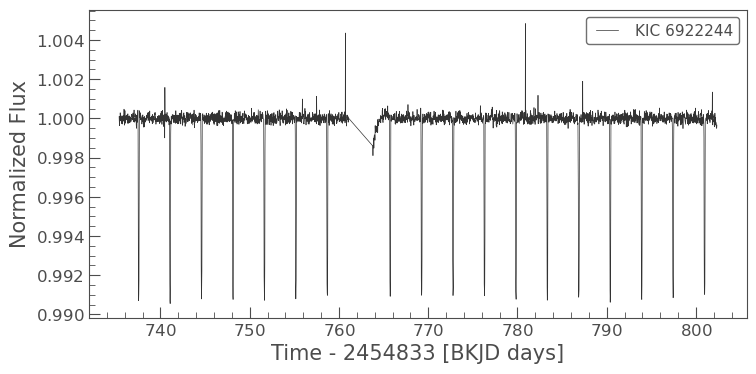

In [58]:
curve_flattened = light_curve.flatten()
curve_flattened.plot();

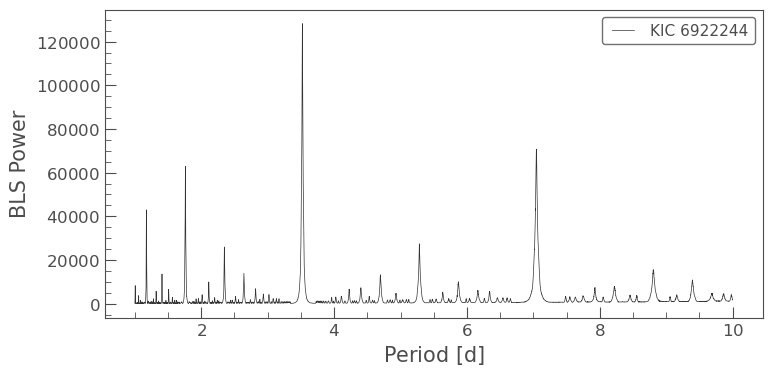

In [59]:
periodogram = curve_flattened.to_periodogram(method="bls", period=np.arange(1, 10, 0.001))
periodogram.plot();

In [60]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.5f}'.format(best_fit_period))

Best fit period: 3.52200 d


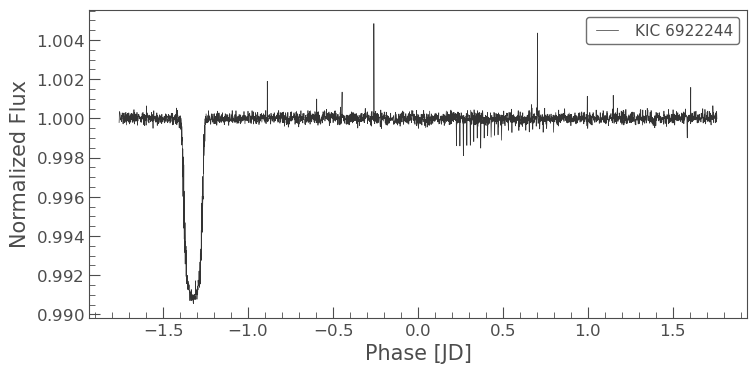

In [61]:
curve_flattened.fold(best_fit_period).plot();

## Combining several measurements
Cool, we've observed some kind of pattern. However, one observation is arguably not enough. Therefore, let's consider all obervations of this galaxy available.

To do this, we need to be smart about way we combine measurements, which are spanning 4 years. And, to make long story short, during this period, settings of the rectangular charge-coupled device (CCD) cameras might have changed (as well as utilized camera itself).

If we make similar prompt to the previous one, but remove quarter specification. We would get data across *all quarters*. Also, now we would load lightcurves straight away, just because we can:

In [35]:
search_result = lk.search_lightcurve('KIC 6922244', author="Kepler", cadence="long")
search_result

#,mission,year,author,exptime,target_name,distance
,,,,s,,arcsec
0,Kepler Quarter 00,2009,Kepler,1800,kplr006922244,0.0
1,Kepler Quarter 01,2009,Kepler,1800,kplr006922244,0.0
2,Kepler Quarter 02,2009,Kepler,1800,kplr006922244,0.0
3,Kepler Quarter 03,2009,Kepler,1800,kplr006922244,0.0
4,Kepler Quarter 04,2010,Kepler,1800,kplr006922244,0.0
5,Kepler Quarter 05,2010,Kepler,1800,kplr006922244,0.0
6,Kepler Quarter 06,2010,Kepler,1800,kplr006922244,0.0
7,Kepler Quarter 07,2010,Kepler,1800,kplr006922244,0.0
8,Kepler Quarter 10,2011,Kepler,1800,kplr006922244,0.0


In [36]:
light_curves = search_result.download_all()

And now let's plot it:

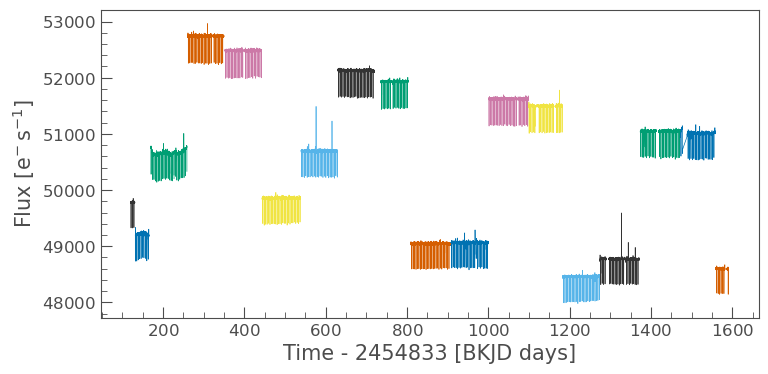

In [37]:
ax = light_curves[0].plot(label=None)
for lc in light_curves[1:]:
    lc.plot(ax=ax, label=None)

The data here is normalized for each entry separately, yet the mean is clearly differs a lot. 

Lickely, `LightkurveCollection` provides out-of-box method for data contactenation & normalization `stitch()`.

<Axes: xlabel='Time - 2454833 [BKJD days]', ylabel='Normalized Flux'>

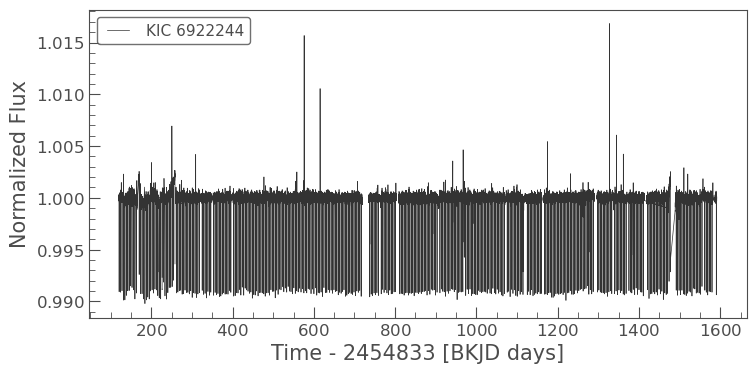

In [48]:
# TODO: why exactly it becomes normalized after that?
light_curves_stiched = light_curves.stitch()
light_curves_stiched.plot()

`period` contains 3892024 points.Periodogram is likely to be large, and slow to evaluate. Consider setting `frequency_factor` to a higher value.


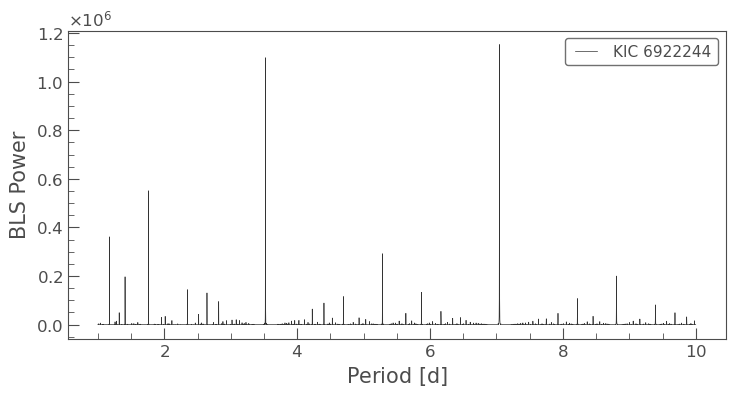

In [64]:
periodogram = light_curves_stiched.flatten().to_periodogram(method="bls", period=np.arange(1.0, 10, 0.001))
periodogram.plot();

In [65]:
best_fit_period = periodogram.period_at_max_power
print('Best fit period: {:.5f}'.format(best_fit_period))

Best fit period: 7.04500 d


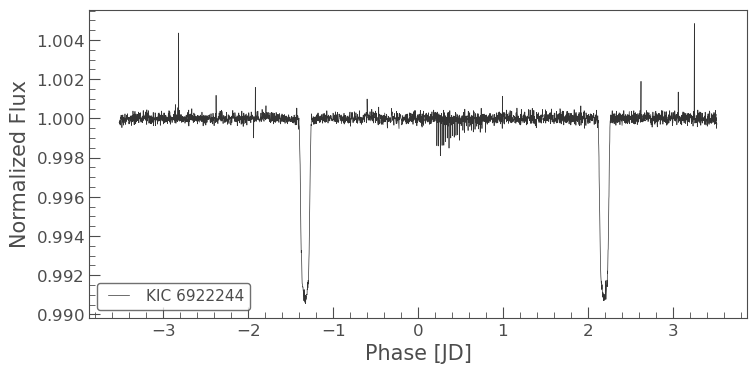

In [66]:
curve_flattened.fold(best_fit_period).plot();